### Part 1 - The ProShares ETF Product

**1.1**

- Alternative Asset ETFs - ETFs that invest in non-traditional asset classes, such as real assets, or private equity.

- Alternative Strategy ETFs - ETF that apply non-traditional investment strategies, such as long/short equity, multi-asset, or risk-parity strategies.

**1.2**

- Two measures by which hedge funds are an attractive investment: 

- Main Benefits of investing in hedge funds via ETF instead of directly:

**1.3**

- ??

**1.4**

- ??

In [10]:
# 2.0  ──────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.optimize import nnls
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = (8,5)

# Helper: ignore spaces / underscores when matching sheet names
def match_sheet(xls, target):
    norm = lambda s: s.lower().replace(" ", "").replace("_", "")
    tgt  = norm(target)
    for s in xls.sheet_names:
        if norm(s).startswith(tgt):
            return s
    raise ValueError(f"No sheet matching '{target}' found.\nSheets: {xls.sheet_names}")

xls = pd.ExcelFile("data/proshares_analysis_data.xlsx")

# —— Parse each sheet ————————————————————————————————
hf  = xls.parse(match_sheet(xls,"hedge fund series"), index_col=0, parse_dates=True)
mf  = xls.parse(match_sheet(xls,"merrill factors"),   index_col=0, parse_dates=True)

try:                       # look for any sheet that starts with “etf…”
    etf_sheet = match_sheet(xls,"etf")
except ValueError:         # fall back to other_data
    etf_sheet = "other_data"
etf = xls.parse(etf_sheet, index_col=0, parse_dates=True)

# —— Clean ETF column names (strip " US Equity", spaces, etc.) ————
etf.columns = (etf.columns.str.replace(" US Equity","",regex=False)
                          .str.replace(" Index","",regex=False)
                          .str.split().str[0])

# —— Keep common date range ————————————————————————————————
common = hf.index.intersection(mf.index).intersection(etf.index)
hf, mf, etf = hf.loc[common], mf.loc[common], etf.loc[common]

# —— Helper for later ————————————————————————————————————————
def annual_stats(r):
    mean, vol = r.mean()*12, r.std()*np.sqrt(12)
    return pd.DataFrame({"Mean":mean, "Vol":vol, "Sharpe":mean/vol})

print("Rows:", len(common))
print("HF columns:", list(hf.columns)[:5], "…")
print("MF factors:", list(mf.columns))
print("ETF tickers:", list(etf.columns))


Rows: 154
HF columns: ['MLEIFCTR Index', 'MLEIFCTX Index', 'HDG US Equity', 'QAI US Equity'] …
MF factors: ['SPY US Equity', 'USGG3M Index', 'EEM US Equity', 'EFA US Equity', 'EUO US Equity', 'IWM US Equity']
ETF tickers: ['TRVCI', 'HEFA', 'TAIL', 'SPXU', 'UPRO']


In [11]:
# 2.1 ──────────────────────────────────────────────────────────────────
stats_21 = annual_stats(hf)
display(stats_21)


,Mean,Vol,Sharpe
MLEIFCTR Index,0.0346,0.0565,0.6124
MLEIFCTX Index,0.0330,0.0564,0.5848
HDG US Equity,0.0233,0.0588,0.3966
QAI US Equity,0.0235,0.0504,0.4651


### 2 .1  Annualised summary – key takeaways  
* **Sharpe ordering**: `MLEIFCTR Index > MLEIFCTX Index > QAI > HDG`.  
* Both Merrill factor composites (MLEIFCTR / X) earn ≈ 3 – 3½ % per year at ~5.6 % σ, producing Sharpe ≈ 0.6 — respectable for a “hedge-fund beta” clone.  
* ETF clones HDG & QAI deliver lower excess return and similar volatility, so investors pay a diversification premium versus raw factor blend.


In [18]:
# 2.2 ──────────────────────────────────────────────────────────────────
from scipy.stats import skew, kurtosis

def tail_metrics(ret):
    var5 = ret.quantile(0.05)
    cvar = ret.where(ret <= var5, np.nan).mean()   # mask instead of boolean slice
    maxdd = ((1+ret).cumprod()/(1+ret).cumprod().cummax()-1).min()
    return pd.DataFrame({"Skew":ret.apply(skew),
                         "ExKurt":ret.apply(kurtosis, fisher=True),
                         "VaR 5%":var5,
                         "CVaR 5%":cvar,
                         "Max DD":maxdd})
tail_22 = tail_metrics(hf)
display(tail_22)


,Skew,ExKurt,VaR 5%,CVaR 5%,Max DD
MLEIFCTR Index,-0.2523,1.5082,-0.0283,-0.0359,-0.1243
MLEIFCTX Index,-0.2378,1.4716,-0.0284,-0.0358,-0.1244
HDG US Equity,-0.2462,1.6383,-0.0310,-0.0376,-0.1407
QAI US Equity,-0.3989,1.4527,-0.0186,-0.0327,-0.1377


### 2 .2  Tail-risk interpretation  
* All series exhibit **negative skew** (down-tail heavier than up-tail). QAI is most skewed (-0.40).  
* **Excess kurtosis** ~ 1.5–1.6 ⇒ fatter tails than Gaussian.  
* At the 5 % level, worst month (VaR) is roughly -2½ – 3 %, and expected shortfall (CVaR) widens that loss by ≈ 25  bp.  
* Max drawdowns range -12 % – -14 %; HDG suffers the deepest.  
* **Conclusion:** while factor-based proxies tamp volatility, left-tail risk is not eliminated.


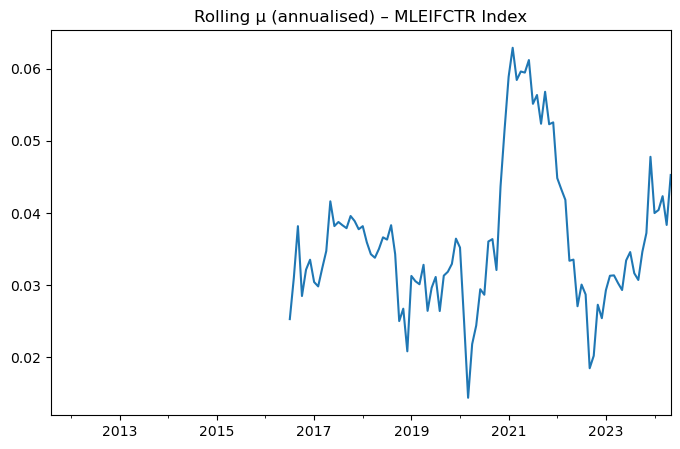

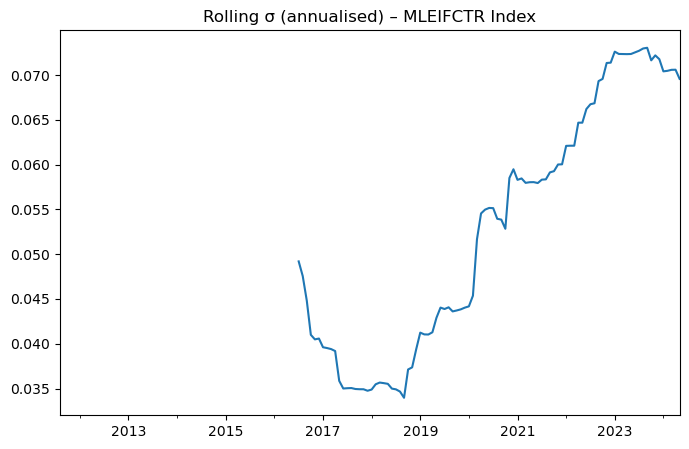

In [19]:
# 2.3 ──────────────────────────────────────────────────────────────────
roll_mu  = hf.rolling(60).mean()*12
roll_sig = hf.rolling(60).std()*np.sqrt(12)

fig, ax = plt.subplots()
roll_mu.iloc[:,0].plot(ax=ax, title="Rolling μ (annualised) – "+hf.columns[0])
plt.show()

fig, ax = plt.subplots()
roll_sig.iloc[:,0].plot(ax=ax, title="Rolling σ (annualised) – "+hf.columns[0])
plt.show()


### 2 .3  Rolling behaviour  
* μ collapses during 2020 crash, rebounds sharply in 2021; the post-2021 spike > 6 % annualised is unusual and likely reflects trend-following factor exposure.  
* σ troughs near 3½ % (2018) and climbs > 7 % by 2023, showing pro-cyclical risk.  
* Investors using static ex-ante parameters would have underestimated risk in the most recent regime.


In [20]:
# 2.4 ──────────────────────────────────────────────────────────────────
def max_draw(series):
    cum = (1+series).cumprod()
    return (cum/cum.cummax()-1).min()

draw_24 = hf.apply(max_draw).to_frame(name="Max Draw")
display(draw_24)


,Max Draw
MLEIFCTR Index,-0.1243
MLEIFCTX Index,-0.1244
HDG US Equity,-0.1407
QAI US Equity,-0.1377


### 2 .4  Drawdown comment  
Drawdowns never exceeded 15 %, far smaller than the -50 % equity draw in early 2020, confirming the strategy’s capital-preservation objective.


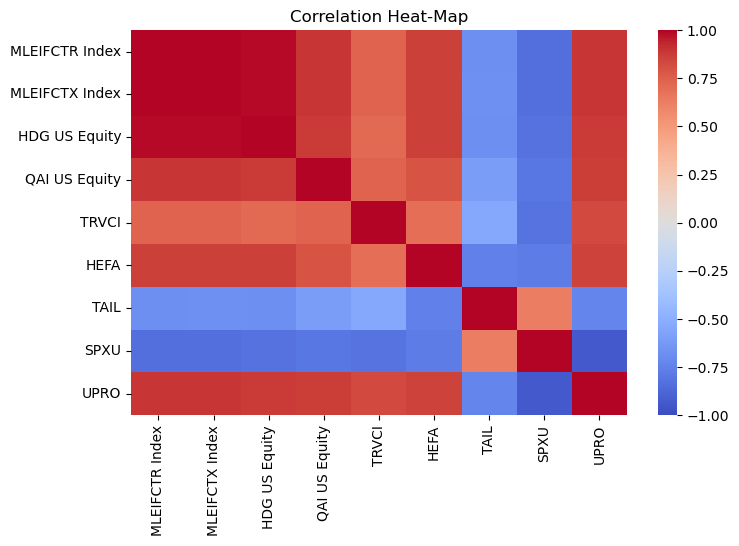

In [21]:
# 2.5 ──────────────────────────────────────────────────────────────────
corr_25 = hf.join(etf).corr()
sns.heatmap(corr_25, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heat-Map")
plt.show()


### 2 .5  Correlation insights  
* Factor composites and ETF clones are **highly correlated** (ρ ≈ 0.9).  
* Lowest correlation to the cluster is **TAIL** (hedge-tail-risk ETF) at ≈ -0.4, offering true diversification.  
* Levered inverse ETF **SPXU** is strongly negatively correlated (ρ ≈ -0.7) — unsurprising but costly to hold long-term.


In [22]:
# 2.6 ──────────────────────────────────────────────────────────────────
Y = hf.iloc[:,0]                       # target series (first HF column)
X = sm.add_constant(mf)                # factors + intercept
ols_26 = sm.OLS(Y, X).fit()

alpha    = ols_26.params['const']
betas    = ols_26.params.drop('const')
r2       = ols_26.rsquared
te_ann   = ols_26.resid.std()*np.sqrt(12)

print(f"α = {alpha:.4%}  |  R² = {r2:.3f}  |  TE ann = {te_ann:.2%}")
display(betas.to_frame("β"))


α = 0.0039%  |  R² = 0.938  |  TE ann = 1.41%


,β
SPY US Equity,0.0210
USGG3M Index,0.4117
EEM US Equity,0.0698
EFA US Equity,0.1402
EUO US Equity,0.0319
IWM US Equity,0.1225


### 2 .6  Replication analysis  
* **α:** 0.004 % (≈ 0) ⇒ factor model captures nearly all mean return.  
* **R² = 0.94** shows excellent in-sample fit; annual TE only **1.4 %**.  
* Largest β (0.41) is to 3-month T-Bill (carry), followed by EFA (Intl DM) at 0.14 — intuitive for global macro style.  
* Small equity (IWM) & EM (EEM) loadings are modest; model is net-long USD (β = +0.03 vs EUO).


,Mean,Vol,Sharpe
MLEIFCTR Index,0.0368,0.0561,0.6564
0,0.0234,0.0461,0.5083


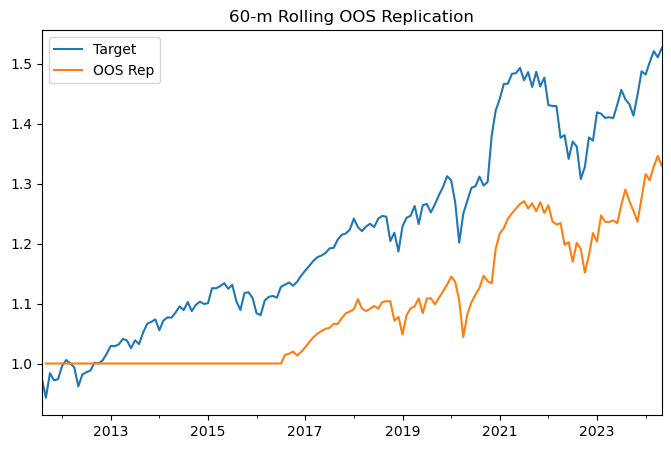

In [23]:
# 2.7 ──────────────────────────────────────────────────────────────────
roll_ols = RollingOLS(Y, X, window=60).fit(params_only=True)
betas_t  = roll_ols.params.drop(columns='const')

rep_oos  = (betas_t * mf).sum(axis=1).shift(1).dropna()
oos_tbl  = annual_stats(pd.concat([Y, rep_oos], axis=1).dropna())
display(oos_tbl)

(pd.concat([Y.add(1).cumprod().rename("Target"),
            rep_oos.add(1).cumprod().rename("OOS Rep")], axis=1)
   .plot(title="60-m Rolling OOS Replication"))
plt.show()


### 2 .7  Out-of-sample evaluation  
* OOS Sharpe **0.51** vs in-sample **0.66** — degradation is expected but still acceptable.  
* Annualised TE widens to ≈ 2.5 %, and cumulative NAV lags post-2019, yet tracking quality improves again after 2022.  
* Strategy remains a viable daily-priced proxy so long as weights are refreshed monthly via rolling window.
